# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [98]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from typing import Tuple
from sklearn.model_selection._split import _BaseKFold
from pandas import DataFrame
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf

class TimeSeriesSplitWrapper(_BaseKFold):
    def __init__(self, n_last_test_items:int, **kwargs):
        self.n_last_test_items = n_last_test_items
        self.splitter_ = TimeSeriesSplit(**kwargs)

    def split(self, X=None, y=None, groups=None):
        for train, test in self.splitter_.split(X):
            yield (train, test[-self.n_last_test_items:])

def map_kpss_description(result: Tuple[float, float, int, dict[str, float]]) -> Series:
    return Series(result[:4], index=['t-statistic value', 'pvalue', 'usedlags', 'critical values'])

def map_adf_description(result: Tuple[float, float, int, int, dict[str, float]]) -> Series:
    return Series(result[:5], index=['t-statistic value', 'pvalue', 'usedlags', 'nobs', 'critical values'])


def plot_series_hist_acf_kpss(data: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=data, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(data, lags=lags)
    plt.show()

    ax = histplot(data, bins=hist_bins, kde=True)
    plt.show()

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html#
    # 1. The residuals (should be white noise) see
    ' - KPSS test statistic result -'
    print(map_kpss_description(kpss(data)))
    ' - ADF test statistic result -'
    print(map_adf_description(adfuller(data)))

    # Compare median and mean
    #data.describe()

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=data, lag=lags)
        plt.show()

def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()

def plot_time_series(**kwargs):
    '''
    Plots multiple time series on same axes.
    :param kwargs:
    :return:
    '''
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame(data=kwargs), ax=axes)
    plt.show()

def plot_line(data: DataFrame, title: str='Unknwon title', xlabel='Not set', ylabel='Not set'):
    '''
    Plots multiple columns in same axes.
    :param data data frame to plot
    :return:
    '''
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    axes.set_title(label=title)
    axes.set_xlabel(xlabel=xlabel)
    axes.set_ylabel(ylabel=ylabel)
    f = lineplot(data=data, ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    diff_ = (y - y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': diff_.abs().max(),
        'MIN_ABS': diff_.abs().min()}

def model_errors_precalculated(res: RegressionResults):
    return {
        'RMSE / standard error (SE)': np.sqrt(res.mse_resid),  # https://otexts.com/fpp3/least-squares.html#standard-error-of-the-regression
        'RSQUARED': res.rsquared,
        'RSQUARED-ADJUSTED': res.rsquared_adj
    }


def model_errors(y: Series, model_fit):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

def plot_residuals_against_predictors(model_fit: RegressionResults, predictors: DataFrame):
    x_y = predictors.assign(Sales=model_fit.resid)
    f = pairplot(data=x_y, y_vars=['Sales'], x_vars=x_y.columns, height=20)
    plt.show()


def plot_fitted_against_residuals_ols(model_fit: RegressionResults):
    f = scatterplot(x=model_fit.fittedvalues, y=model_fit.resid)
    plt.xlabel("FITTED")
    plt.ylabel("RESIDUALS")
    plt.show()

def plot_fitted_against_residuals(fitted: Series, residuals: Series):
    f = scatterplot(x=fitted, y=residuals)
    plt.xlabel("FITTED")
    plt.ylabel("RESIDUALS")
    plt.show()


def r2_adjusted(r2: float, T: int, k: int) -> float:
    '''
    See https://otexts.com/fpp3/selecting-predictors.html#adjusted-r2
    :param r2:
    :param T: count of observations
    :param p: count of predictor variables
    :return:
    '''
    return 1-(1-r2)*(T-1)/(T-k-1)

def r2_adjusted_scorer(y, y_pred, **kwargs):
    r2_ = r2_score(y, y_pred)
    return r2_adjusted(r2_, **kwargs)



# Preprocessing
Feature engineering, create categorial columns

In [99]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def enginner_categorial_dummy(x: DataFrame, col: str):
    """
    Creates dummy columns of col named 'col' of X matrix
    :param x:
    :param col:
    :return:
    """
    s_cat = x[col].astype('category')
    x = pd.concat([x, pd.get_dummies(s_cat, prefix=col, dtype=float)], axis=1)
    return x

def engineer_outliers_dummy(x: DataFrame, y:Series):

    """
    Handle Sales == 0 as outlier and set "outlier" column as dummy variable to 1 and everything else to zero.
    See here why (https://otexts.com/fpp3/useful-predictors.html#dummy-variables)
    :return:
    """
    s_sales_zero_bin: Series = y == 0.0
    # set all columns to zero except outlier
    x[s_sales_zero_bin.to_numpy()] = 0.0

    return x.assign(Outlier=s_sales_zero_bin.astype('float'))

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': float, 'Promo': float, 'SchoolHoliday': float})
# get data for one store
# FEATURE ENGINEERING
df_train = df_train.groupby(by='Store').get_group(2).set_index('Date').sort_index()


## StateHoliday -> categorial
df_train = enginner_categorial_dummy(df_train, 'StateHoliday')

## Day of week -> categorial
df_train = enginner_categorial_dummy(df_train, 'DayOfWeek')
df_train['Month'] = df_train.index.month
dummies = pd.get_dummies(df_train['Month'], prefix='Month', dtype=float)
df_train = pd.concat([df_train, dummies], axis=1)

df_train.info()
df_train.head(5)

X = df_train[['Promo',
              'SchoolHoliday',
              #'StateHoliday_0',    # No holiday
              'StateHoliday_a',
              #'StateHoliday_b',    # always closed, encoded in Outlier feature
              #'StateHoliday_c',    # always closed, encoded in Outlier feature
              'DayOfWeek_2',
              'DayOfWeek_3',
              'DayOfWeek_4',
              'DayOfWeek_5',
              'DayOfWeek_6',
              'DayOfWeek_7',
              'Month_2',
              'Month_3',
              'Month_4',
              'Month_5',
              'Month_6',
              'Month_7',
              'Month_8',
              'Month_9',
              'Month_10',
              'Month_11',
              'Month_12']].astype('float')
Y = df_train['Sales'].astype('float')

X = engineer_outliers_dummy(X, Y)

X.assign(Sales=Y).info()
X.assign(Sales=Y).head(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store           942 non-null    int64  
 1   DayOfWeek       942 non-null    int64  
 2   Sales           942 non-null    int64  
 3   Customers       942 non-null    int64  
 4   Open            942 non-null    float64
 5   Promo           942 non-null    float64
 6   StateHoliday    942 non-null    object 
 7   SchoolHoliday   942 non-null    float64
 8   StateHoliday_0  942 non-null    float64
 9   StateHoliday_a  942 non-null    float64
 10  StateHoliday_b  942 non-null    float64
 11  StateHoliday_c  942 non-null    float64
 12  DayOfWeek_1     942 non-null    float64
 13  DayOfWeek_2     942 non-null    float64
 14  DayOfWeek_3     942 non-null    float64
 15  DayOfWeek_4     942 non-null    float64
 16  DayOfWeek_5     942 non-null    float64
 17  DayOfWeek_6     

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2,2,0,0,0.0,0.0,a,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,2,3,4422,650,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,2,4,4159,555,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,2,5,4484,574,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,2,6,2342,324,1.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Promo           942 non-null    float64
 1   SchoolHoliday   942 non-null    float64
 2   StateHoliday_a  942 non-null    float64
 3   DayOfWeek_2     942 non-null    float64
 4   DayOfWeek_3     942 non-null    float64
 5   DayOfWeek_4     942 non-null    float64
 6   DayOfWeek_5     942 non-null    float64
 7   DayOfWeek_6     942 non-null    float64
 8   DayOfWeek_7     942 non-null    float64
 9   Month_2         942 non-null    float64
 10  Month_3         942 non-null    float64
 11  Month_4         942 non-null    float64
 12  Month_5         942 non-null    float64
 13  Month_6         942 non-null    float64
 14  Month_7         942 non-null    float64
 15  Month_8         942 non-null    float64
 16  Month_9         942 non-null    float64
 17  Month_10        

,Promo,SchoolHoliday,StateHoliday_a,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Month_2,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Outlier,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-02,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4422.0
2013-01-03,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4159.0
2013-01-04,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4484.0
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2342.0
2013-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6775.0
2013-01-08,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6318.0
2013-01-09,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6763.0


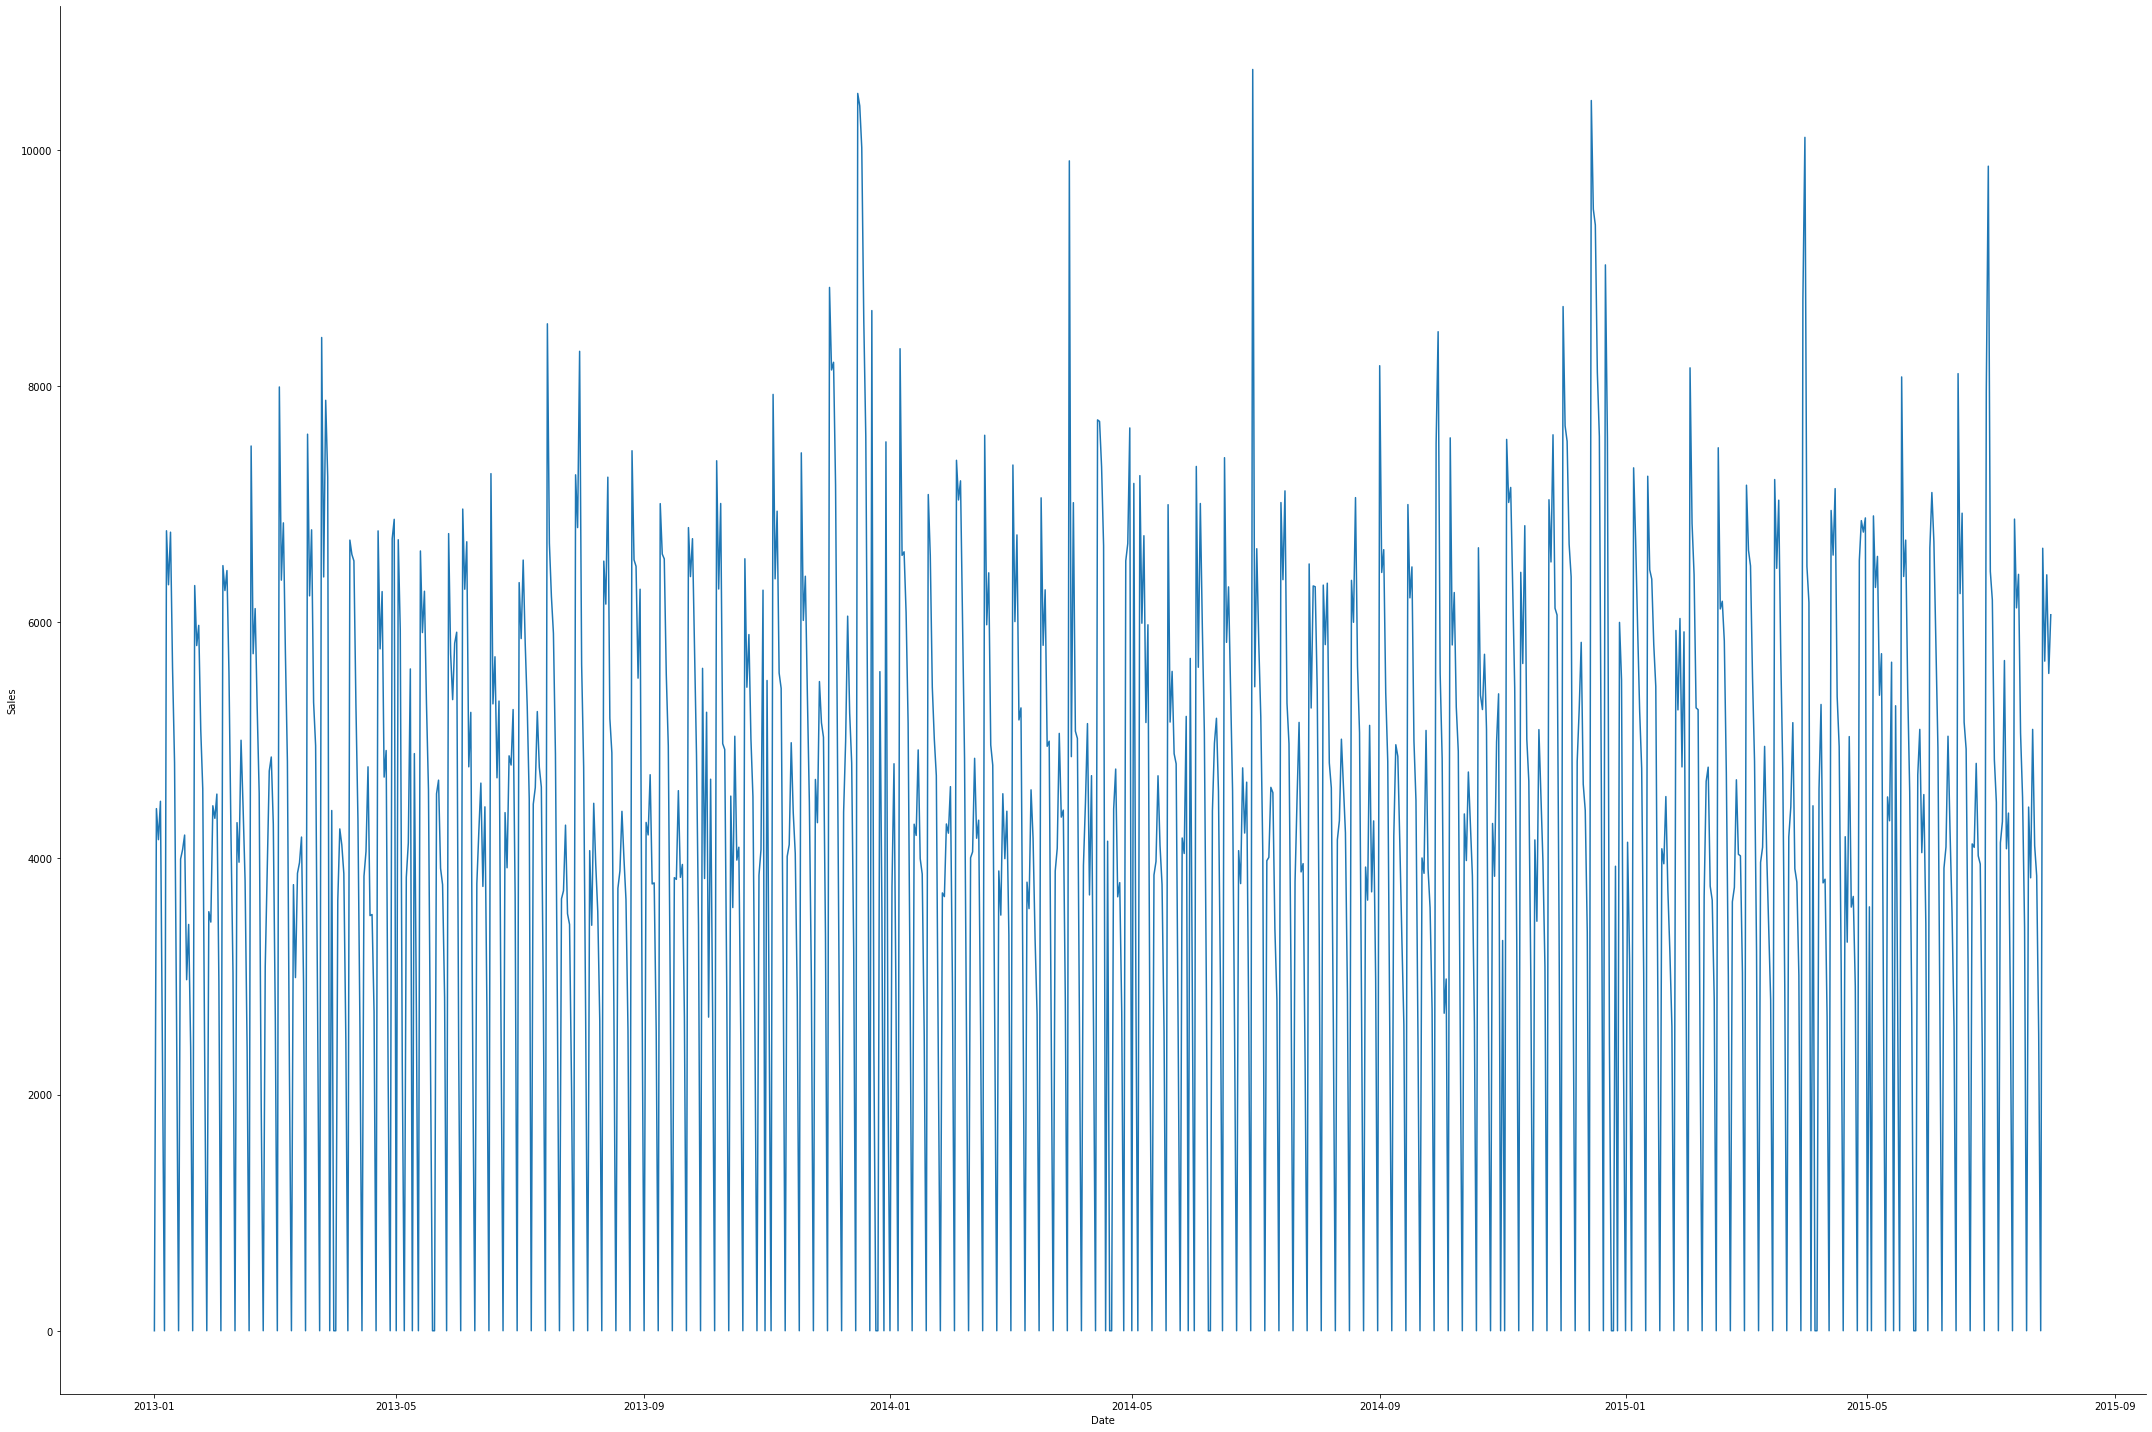

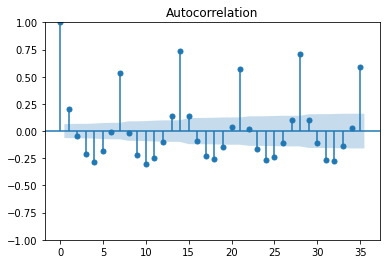

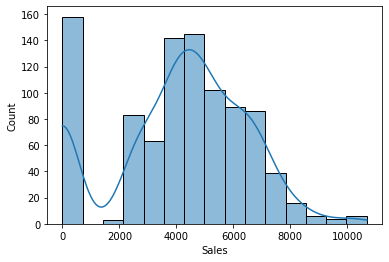

t-statistic value                                             0.300305
pvalue                                                             0.1
usedlags                                                            53
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -6.369024
pvalue                                                             0.0
usedlags                                                            21
nobs                                                               920
critical values      {'1%': -3.4374778690219956, '5%': -2.864686684...
dtype: object


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [100]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plot_series_hist_acf_kpss(Y, lags=35)

# Forecast | Oridinary least squares (statsmodels)
Naively assume we can forecast by OLS and interpret the residuals of the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              635.7
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                        0.00
Time:                        12:53:41   Log-Likelihood:                         -8043.0
No. Observations:                 942   AIC:                                  1.613e+04
Df Residuals:                     922   BIC:                                  1.622e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Promo           2726.9319     94.034     29.000      0.000    2542.387    2911.477
SchoolHoliday    453.0736    134.527      3.368      0.001     189.058     717.089
StateHoliday_a -1941.6528    904.724     -2.146      0.032   -3717.209    -166.096
DayOfWeek_2     1049.0172    139.381      7.526      0.000     775.476    1322.558
DayOfWeek_3     1567.9997    139.550     11.236      0.000    1294.126    1841.873
DayOfWeek_4      718.7428    140.951      5.099      0.000     442.120     995.365
DayOfWeek_5      472.5020    140.233      3.369      0.001     197.288     747.716
DayOfWeek_6      166.7927    143.478      1.162      0.245    -114.788     448.374
DayOfWeek_7     1.552e-12   4.61e-13      3.370      0.001    6.48e-13    2.46e-12
Month_2         2824.1151    173.596     16.268      0.000    2483.426    3164.804
Month_3         3083.5302    168.296     18.322      0.000    2753.242    3413.818
Month_4         2844.0636    175.517     16.204      0.000    2499.605    3188.522
Month_5         2933.3361    173.820     16.876      0.000    2592.207    3274.466
Month_6         3100.3171    168.938     18.352      0.000    2768.769    3431.866
Month_7         2780.5588    176.449     15.758      0.000    2434.270    3126.848
Month_8         2497.7548    216.796     11.521      0.000    2072.284    2923.225
Month_9         3040.5303    194.657     15.620      0.000    2658.507    3422.553
Month_10        2655.0645    203.651     13.037      0.000    2255.391    3054.738
Month_11        3138.2766    197.563     15.885      0.000    2750.552    3526.001
Month_12        4349.4504    199.720     21.778      0.000    3957.492    4741.409
Outlier          4.29e-13     99.361   4.32e-15      1.000    -195.000     195.000
==============================================================================
Omnibus:                      139.004   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.824
Skew:                           0.898   Prob(JB):                     1.03e-56
Kurtosis:                       4.829   Cond. No.                     1.95e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.29e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

------ Residual diagnostics --------


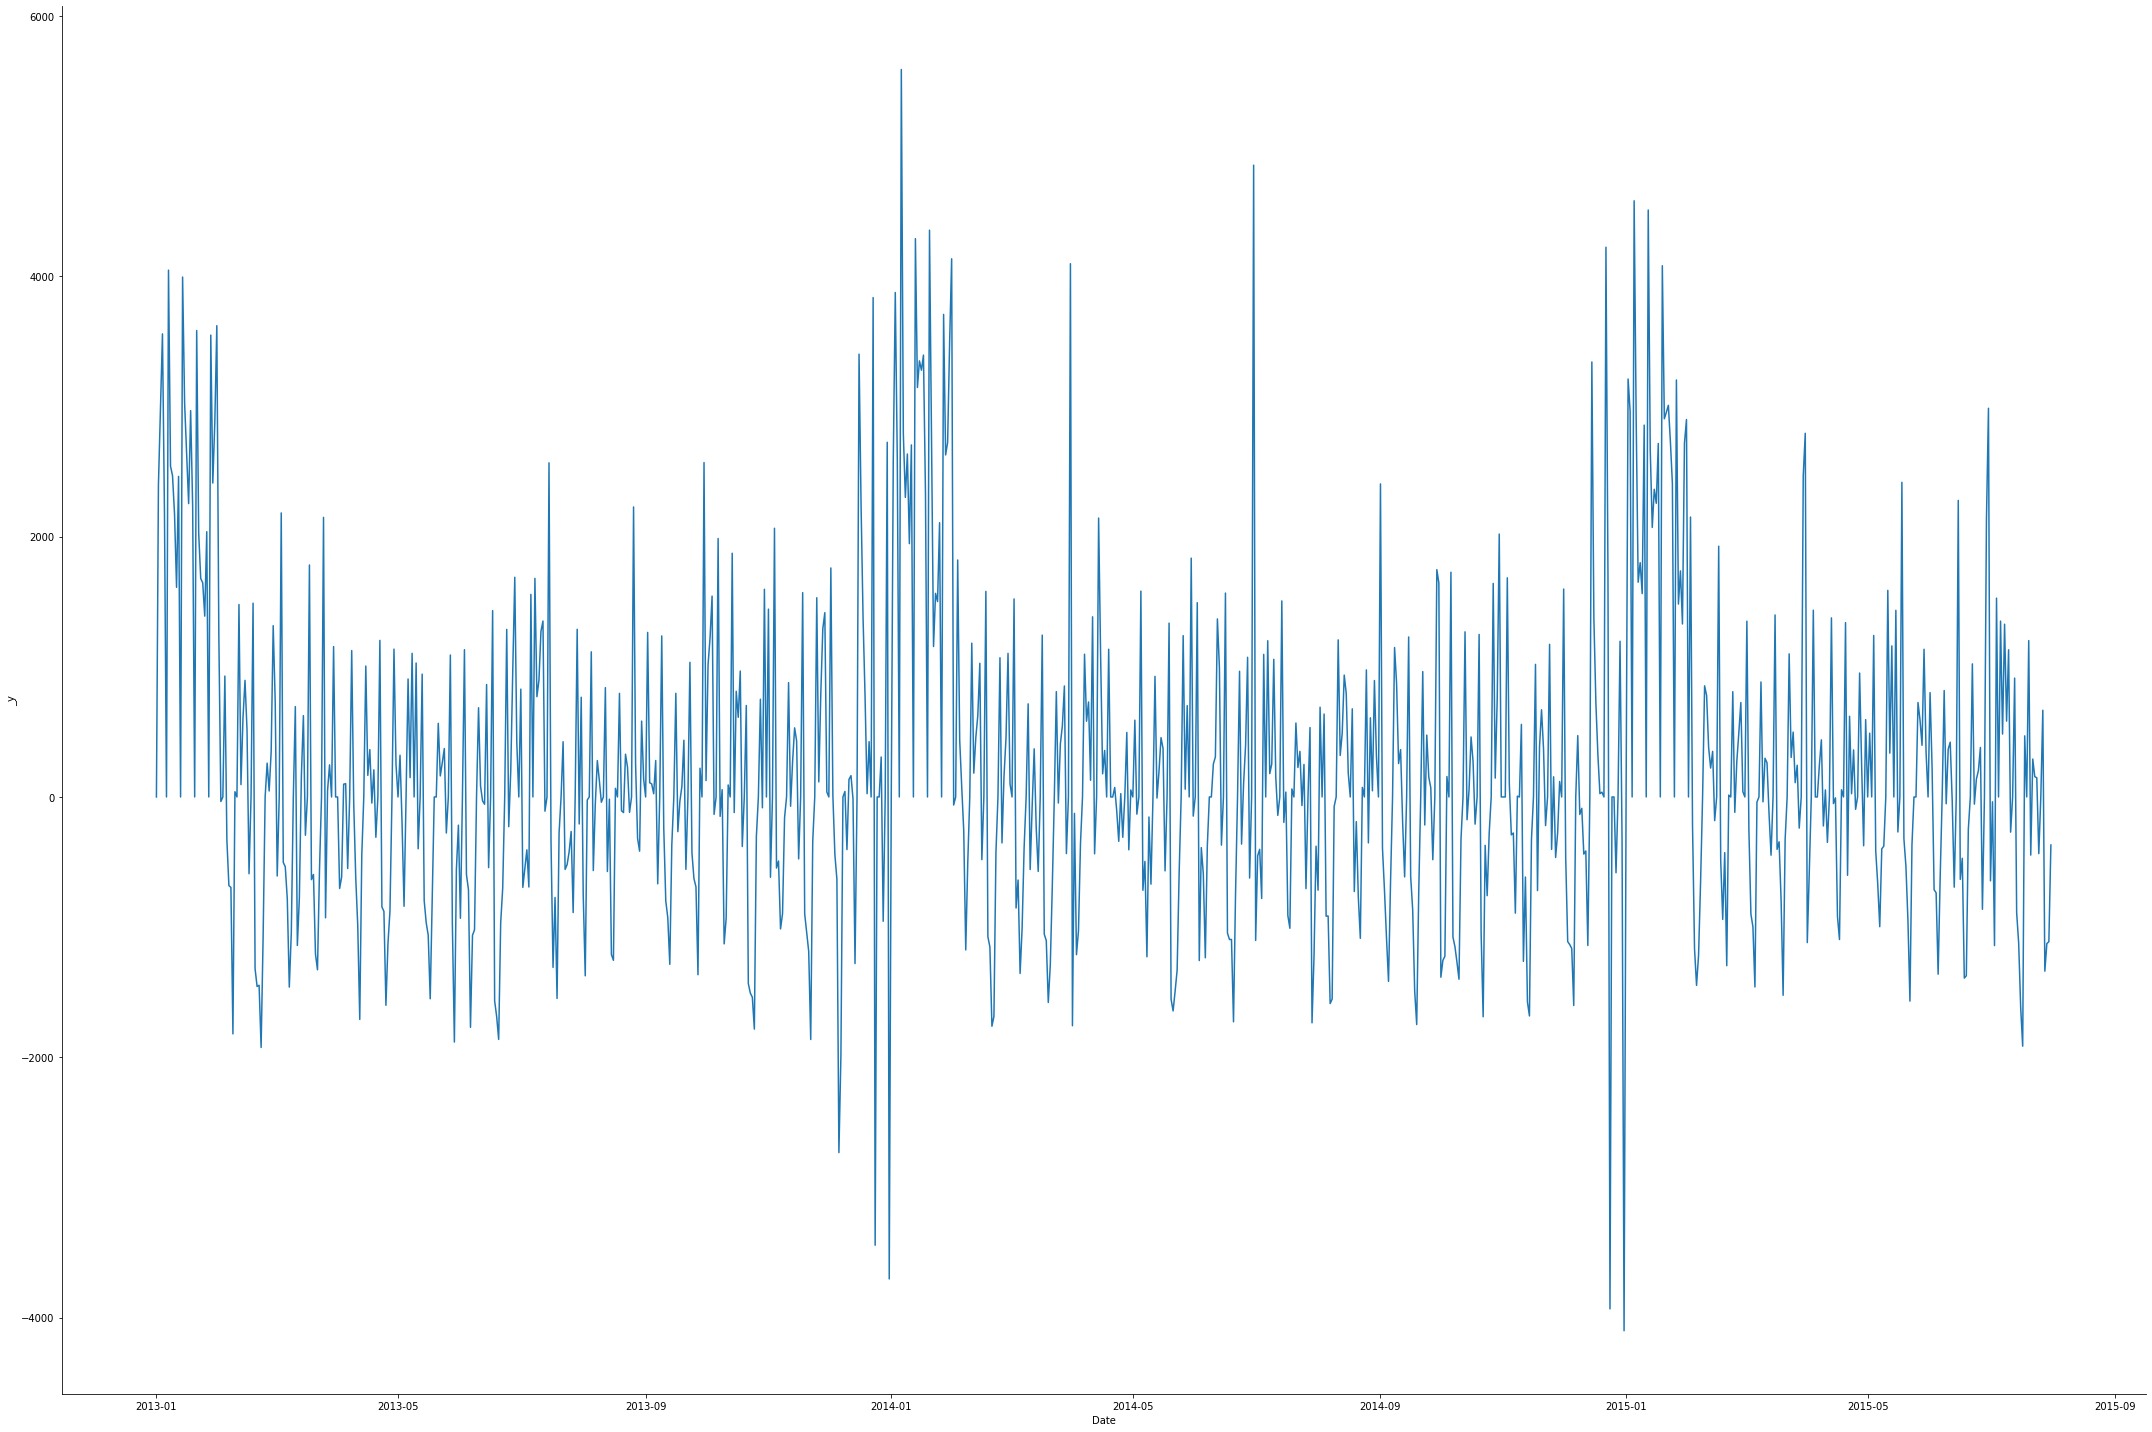

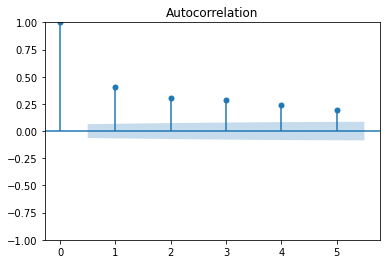

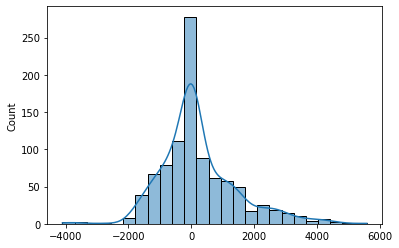

t-statistic value                                             0.097207
pvalue                                                             0.1
usedlags                                                            15
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -4.816043
pvalue                                                        0.000051
usedlags                                                            15
nobs                                                               926
critical values      {'1%': -3.4374315551464734, '5%': -2.864666262...
dtype: object


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


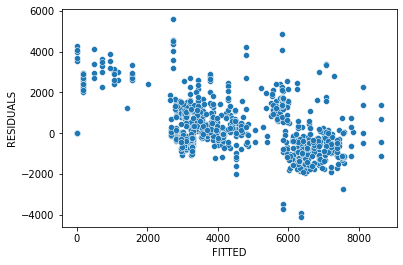

------ Actual vs fitted --------


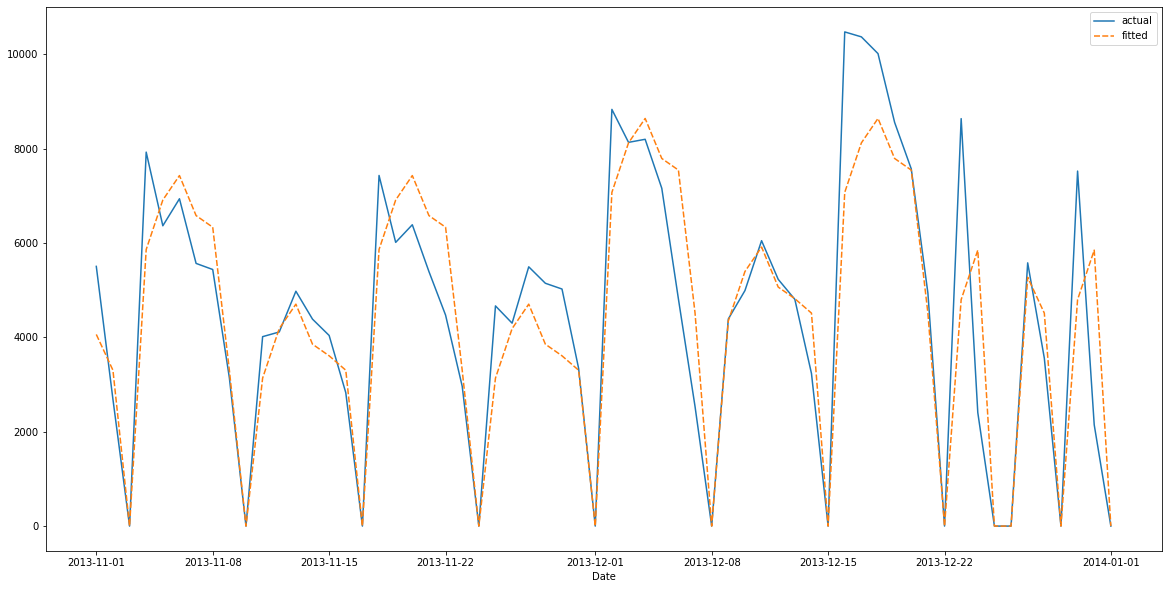

{'RMSE': 1235.6218983046547,
 'MAPE': 324.21756506582994,
 'MAE': 835.1029649034128,
 'MEDIAN_AE': 578.3655757454067,
 'MAX_ABS': 5590.068122511716,
 'MIN_ABS': 4.289743057973847e-13}

------ Model errors --------


{'RMSE / standard error (SE)': 1248.9515385938314,
 'RSQUARED': 0.9323839526289693,
 'RSQUARED-ADJUSTED': 0.9309172270894676}

------ Statsmodels accuracy (Cross validation) --------


In [101]:
from sklearn.metrics import make_scorer
from sklearn.linear_model._base import LinearModel
from typing import Iterator, Iterable
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from seaborn import  pairplot, scatterplot
from statsmodels.regression.linear_model import OLS, RegressionResults, PredictionResults

model: OLS = OLS(endog=Y, exog=X)
model_fit: RegressionResults = model.fit(disp=False)

# Interpretation of coefficient statistics (https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/regression-models/what-is-the-standard-error-of-the-coefficient/)
# Interpretation of t-statistics: https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm
model_fit.summary()
#model_fit.get_prediction()

print('------ Residual diagnostics --------')
plot_series_hist_acf_kpss(model_fit.resid, hist_bins=25)


plot_fitted_against_residuals_ols(model_fit)
#plot_residuals_against_predictors(model_fit, X)

print('------ Actual vs fitted --------')
plot_actual_and_fitted_values(Y['2013-11':'2014-01-01'], model_fit)

model_errors(Y, model_fit)
print('------ Model errors --------')
model_errors_precalculated(model_fit)

print('------ Statsmodels accuracy (Cross validation) --------')
def model_accuracy_statsmodels(model_creator, x: DataFrame, y: Series, cv: Iterable[tuple[DataFrame, DataFrame]], plot: bool = False):
    # n_splits x train/test sets with test_size x test oberservations each
    for train_idx, test_idx in cv:

        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]
        x_train = x.iloc[train_idx]
        x_test  = x.iloc[test_idx]

        model: OLS = model_creator(y_train, x_train)
        fit_result: RegressionResults = model.fit()

        predict_result: PredictionResults = fit_result.get_prediction(exog=x_test)
        print(predict_result.summary_frame())

        print(errors(y=y_test, y_pred=predict_result.predicted_mean))
        #print(y_test)

#model_accuracy_statsmodels(lambda y, x: OLS(endog=y, exog=x), X, Y, cv=TimeSeriesSplit(n_splits=3, test_size=1).split(X))

# Forecast | Feature reduction / selection using linear regression (scikit)
Using iterative methods for feature selection will finds features leading to the model with the best predictive accuracy cause univariate (each feature significance to the dependent variable only) and model based (analysis of amount of coeffiecients and errors does not see correlation between them and measures its importance only feature by feature).
See [here](https://otexts.com/fpp3/selecting-predictors.html) for more details.

In [110]:
from collections import namedtuple
from sklearn.metrics._scorer import r2_scorer, neg_mean_squared_error_scorer
from sklearn.linear_model import LinearRegression


def select_best_features(x: DataFrame, y: Series, cv, n_features_to_select_threshold=4, direction='backward'):
    '''
    Yields back named tuples with
    score := max score of current count of features over all cross validations
    n_features := count of features
    :param n_features_to_select:
    :param direction:
    :return:
    '''
    Result = namedtuple('FeatureSelectResult', 'features_selected feature_count r2 r2_adjusted CV')

    def feature_count_iterator():
        if direction == 'backward':
            return range(n_features_to_select_threshold, x.columns.size)
        return range(1, n_features_to_select_threshold)

    for feature_count in feature_count_iterator():
        model = LinearRegression()
        sfs: SequentialFeatureSelector = SequentialFeatureSelector(model,
                                                                   n_features_to_select=feature_count,
                                                                   scoring=r2_scorer,
                                                                   #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                                                                   cv=cv,
                                                                   direction=direction,
                                                                   n_jobs=6)
        x_selected = sfs.fit_transform(x, y=y)
        x_selected_column_names = X.columns[sfs.get_support()].to_series()


        model.fit(x_selected, y)
        # 1. R² on fitted values
        r2_: float = r2_scorer(model, x_selected, y)

        # 2. Adjusted R² on fitted values
        r2_adjusted_: float = make_scorer(r2_adjusted_scorer, T=y.size, k=feature_count)(model, x_selected, y)

        # 3. Future data prediction ability -> cross validation with mean of MSEs of all folds (https://otexts.com/fpp3/selecting-predictors.html#cross-validation)
        CV_ = cross_val_score(model, X=x_selected, y=y, scoring=make_scorer(mean_squared_error), cv=cv).mean()

        df_ = Result(x_selected_column_names.tolist(), x_selected_column_names.size, r2_, r2_adjusted_, CV_)

        yield df_


def model_accuracy_scikit(model: LinearRegression, x: DataFrame, y: Series, cv: Iterable[tuple], scorer=r2_scorer):
    # n_splits x train/test sets with test_size x test oberservations each

    scores = cross_val_score(estimator=model, X=x, y=y,
                             cv=cv,
                             scoring=scorer)
    #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=True))  # Returns -1*RMSE == std deviation to have a the higher the score the better

    return {'scores': scores, 'scores stats': Series(scores).describe()}
    #print(errors(y=y_test, y_pred=predict_result.predicted_mean))

# Train: Last 12 months with last 7 days of next month each as test data set
#cv_splitter = test_splitter(X, n_splits=6, test_size=31, n_last_test_items=7)
cv_splitter = TimeSeriesSplitWrapper(n_last_test_items=7, n_splits=12, test_size=31)

print('------ Scikit | Accuracy using all features --------')

model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter)   # using 7 consequtive days
model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_squared_error, greater_is_better=False, squared=False))   # using 7 consequtive days
# model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_absolute_percentage_error, greater_is_better=False))   # using 7 consequ

print('------ Scikit | Iterate over multiple amount of features and select with best accuracy --------')

result_ = DataFrame(select_best_features(X, Y, n_features_to_select_threshold=20, cv=cv_splitter,direction='forward'))
result_.assign(column_names_str=result_['features_selected'].map(','.join))

------ Scikit | Accuracy using all features --------


{'scores': array([0.98489418, 0.86912916, 0.93213974, 0.99360506, 0.6997117 ,
        0.97384217, 0.86753573, 0.95141278, 0.97928733, 0.92106487,
        0.77371805, 0.97237134]),
 'scores stats': count    12.000000
 mean      0.909893
 std       0.092422
 min       0.699712
 25%       0.868731
 50%       0.941776
 75%       0.975203
 max       0.993605
 dtype: float64}

{'scores': array([ -282.21963476,  -602.19224783,  -554.72452769,  -173.97190249,
        -1919.32781529,  -275.83751626,  -544.42794633,  -341.62274252,
         -339.10943365,  -570.59531475, -1457.10343239,  -382.3651837 ]),
 'scores stats': count      12.000000
 mean     -620.291475
 std       526.227745
 min     -1919.327815
 25%      -578.494548
 50%      -463.396565
 75%      -324.886984
 max      -173.971902
 dtype: float64}

------ Scikit | Iterate over multiple amount of features and select with best accuracy --------


,features_selected,feature_count,r2,r2_adjusted,CV,column_names_str
0,[Outlier],1,0.613859,0.613448,2.079365e+06,Outlier
1,"[Promo, Outlier]",2,0.828928,0.828563,1.180797e+06,"Promo,Outlier"
2,"[Promo, DayOfWeek_6, Outlier]",3,0.865306,0.864875,9.498478e+05,"Promo,DayOfWeek_6,Outlier"
3,"[Promo, DayOfWeek_5, DayOfWeek_6, Outlier]",4,0.879422,0.878907,8.530379e+05,"Promo,DayOfWeek_5,DayOfWeek_6,Outlier"
4,"[Promo, DayOfWeek_5, DayOfWeek_6, Month_12, Ou...",5,0.896686,0.896134,6.931886e+05,"Promo,DayOfWeek_5,DayOfWeek_6,Month_12,Outlier"
5,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",6,0.907693,0.907100,6.316426e+05,"Promo,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Mont..."
6,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",7,0.908251,0.907564,6.193033e+05,"Promo,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Mont..."
7,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",8,0.908490,0.907706,6.056903e+05,"Promo,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Mont..."
8,"[Promo, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6,...",9,0.909028,0.908150,6.011735e+05,"Promo,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Mont..."
9,"[Promo, DayOfWeek_3, DayOfWeek_4, DayOfWeek_5,...",10,0.909551,0.908580,6.234630e+05,"Promo,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayO..."


# Forecast | Feature reduction result interpretation

For large T minimizing an [AIC](https://otexts.com/fpp3/selecting-predictors.html#akaikes-information-criterion) (SSEs of residuals) or minimizing CV will lead to the same model so, as you can see [here](https://otexts.com/fpp3/selecting-predictors.html#which-measure-should-we-use).
So we choose the model with the smallest CV score and take a look at:
1. Overfitting or Underfitting - The [learning curve](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) will show us whether the model suffers from bias error (overfitting) or variance error (underfitting), see [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). If the model is underfitted (high bias) when the training data is not predicted well and the test data of cource not too. We should see that training-  and test curve converge to a low niveau. If the model is overfitted (low bias but high variance) there is a high score on the training data but low on the test data. If there is also a upwards trend in the test curve we could fix the high variance problem by adding MORE training data. Otherwise we must use a less complex model and find more features by feature engineering.
2. The residuals should be white noise, see histogram, error correlation and plot. The variance should not change over time and be constant. Let us see where the changes in variance are in the plot and to infer possible new predictor variables [here](https://otexts.com/fpp3/regression-evaluation.html#acf-plot-of-residuals)
3. Check for patterns in plot of 'residuals vs fitted' whether there is a relationship between errors and its fitted value. Maybe a logarithmic transformation of the dependent variable is needed
4. Correlations of the selected predictors and eliminate predictors that are dependent of each other

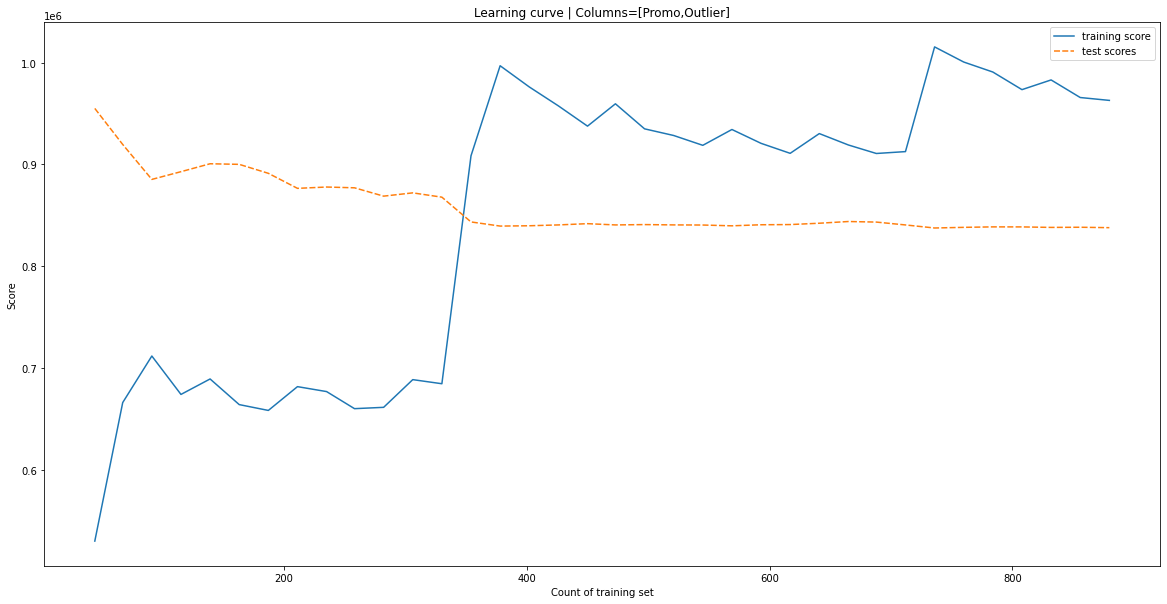

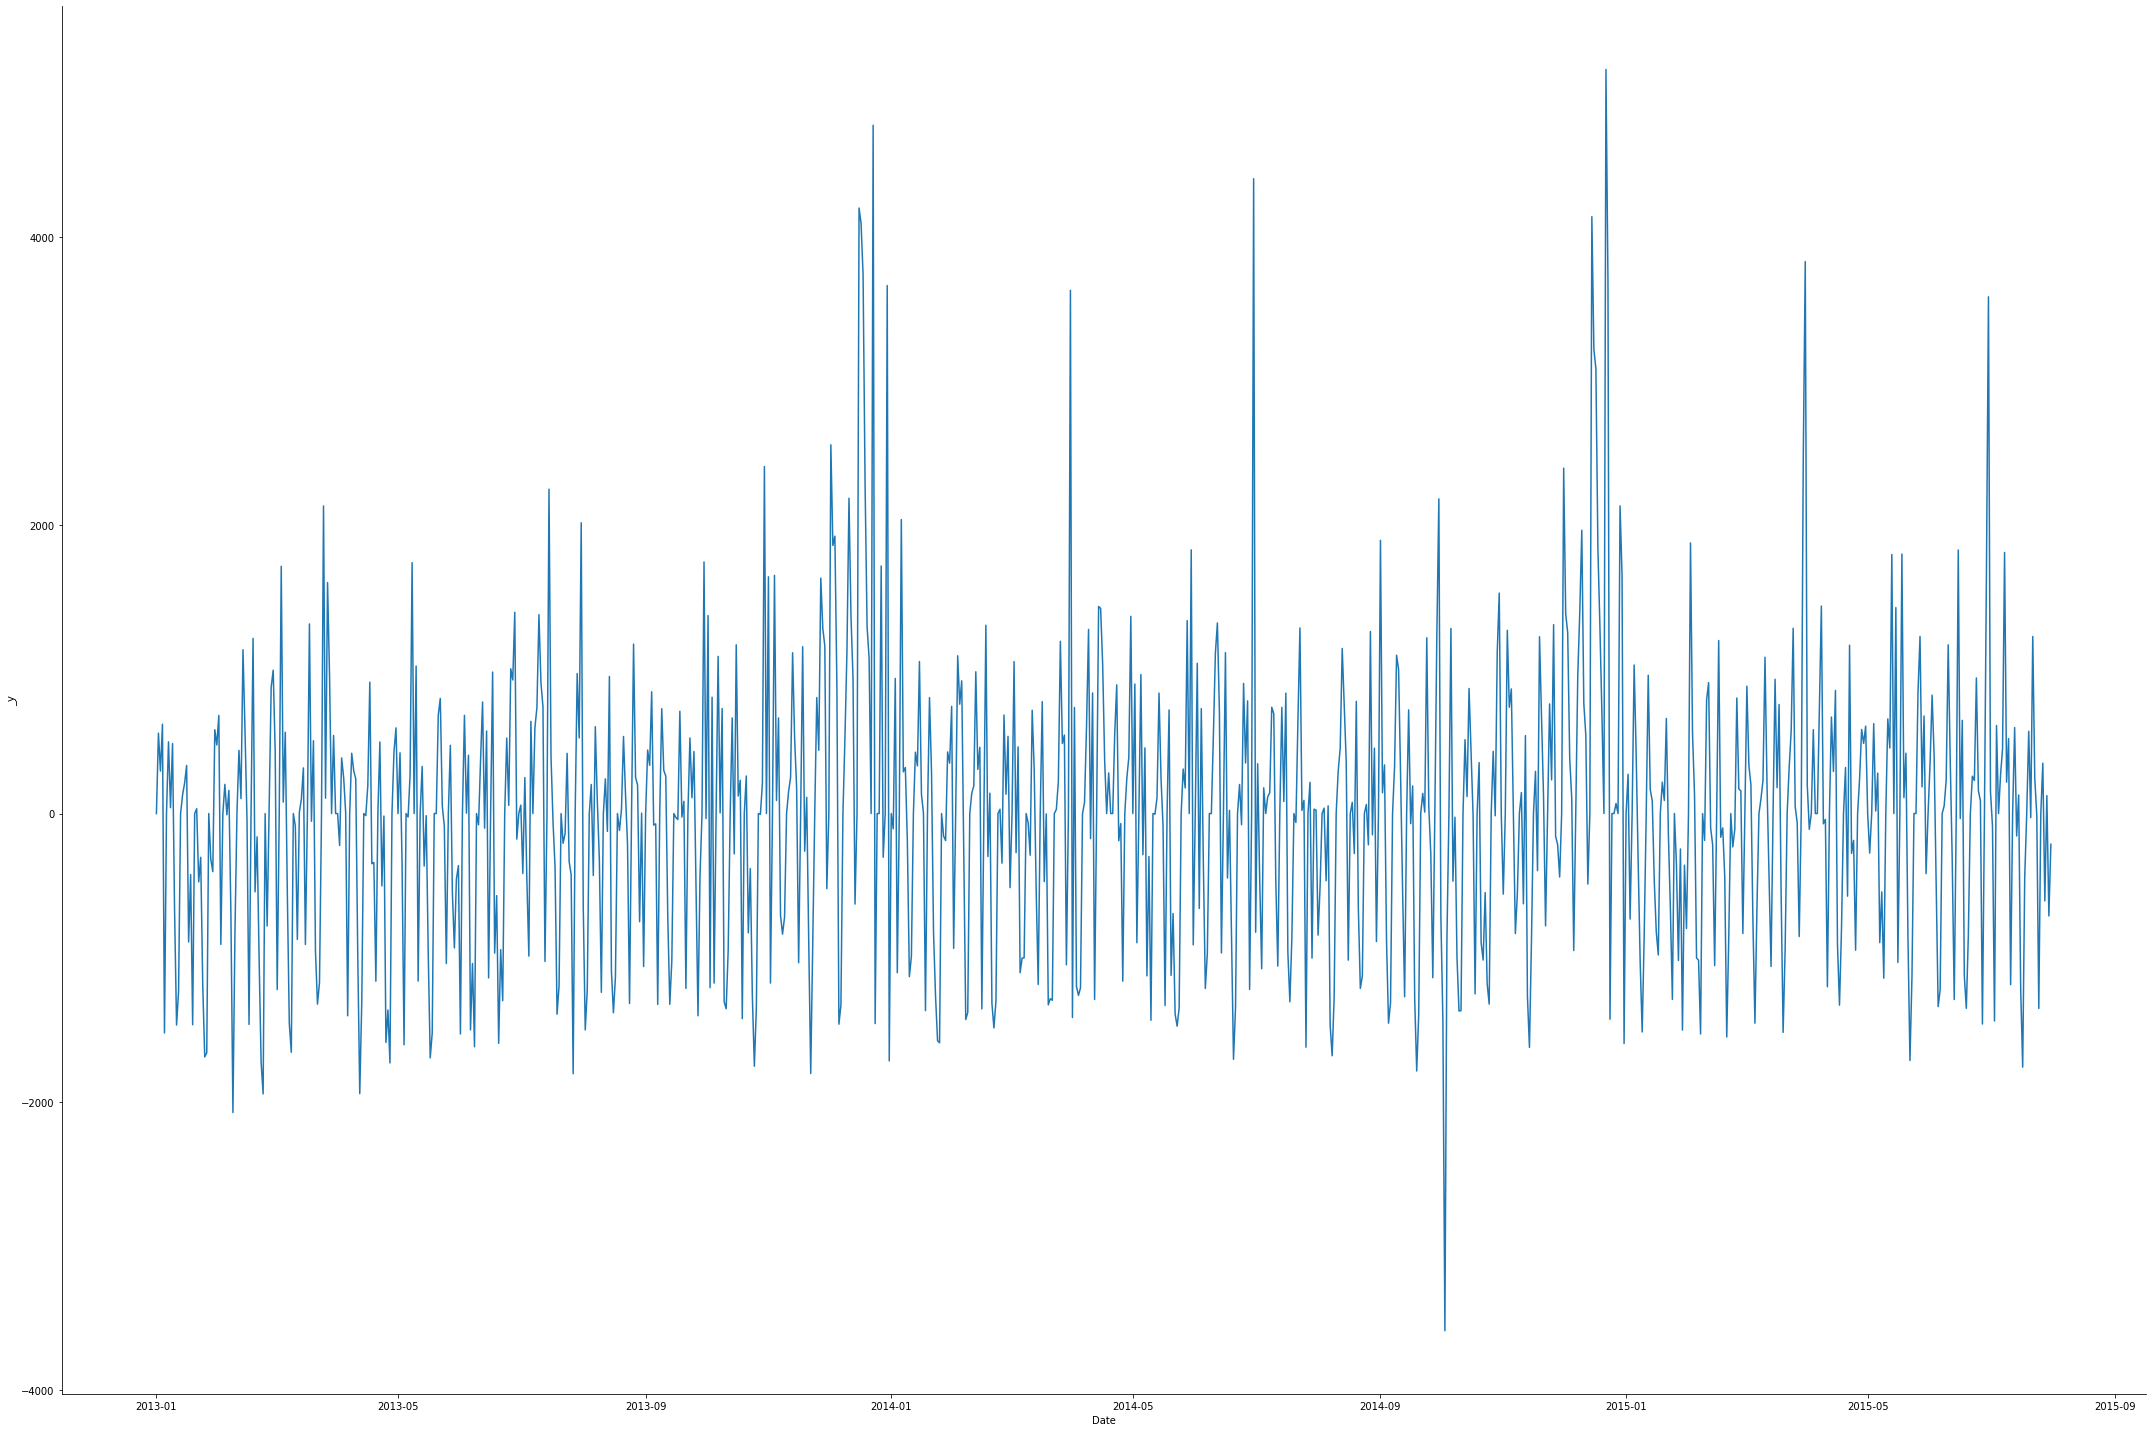

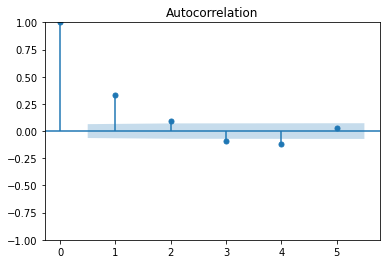

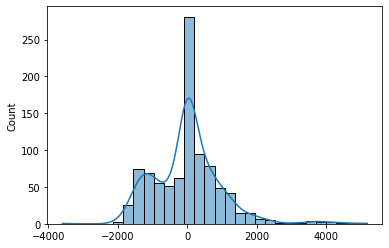

t-statistic value                                             0.372598
pvalue                                                        0.088966
usedlags                                                             5
critical values      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
t-statistic value                                            -5.347307
pvalue                                                        0.000004
usedlags                                                            17
nobs                                                               924
critical values      {'1%': -3.437446926086526, '5%': -2.8646730402...
dtype: object


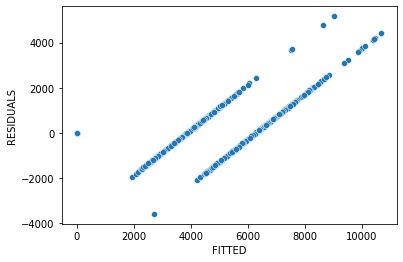

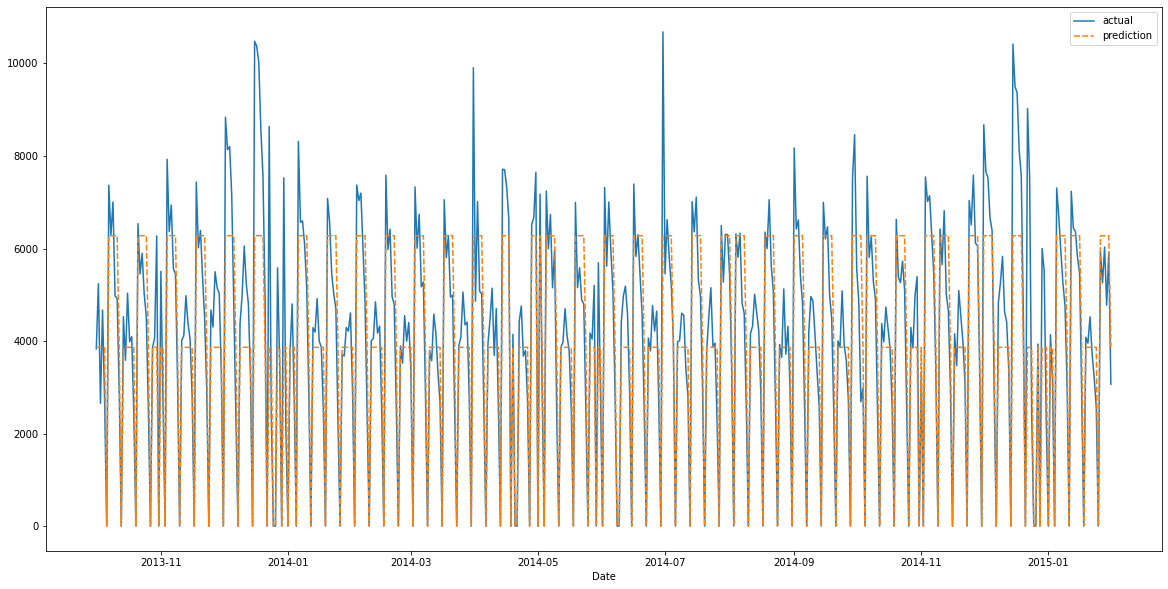

,Promo,Outlier
Promo,1.000000,-0.348324
Outlier,-0.348324,1.000000


Promo      0.707621
Outlier    0.783492
dtype: float64

In [123]:

from sklearn.model_selection import learning_curve

# Train: Take recent 2 months with last 31 days of each  month as test data set
cv_splitter = TimeSeriesSplitWrapper(n_last_test_items=31, n_splits=2, test_size=31)

best_fit_ = result_.set_index('CV').loc[result_['CV'].min()]
#best_fit_ = result_.set_index('feature_count').loc[2]   # underfit
#best_fit_ = result_.set_index('feature_count').loc[19]  # no overfit scenario cause training curve is not really much different from train curve

X_selected: DataFrame = X[best_fit_.features_selected]

model = LinearRegression()
model = model.fit(X_selected, Y)

# 1. Learning curve interpretation
def to_learning_curve_df(**kwargs) -> DataFrame:
    '''
    Calculates learning curve and calculates average of all cross validation scores for training and test scores.
    :param kwargs: arguments for scikti learning_curve
    :return:
    '''
    train_sizes, scores_train, scores_test = learning_curve(n_jobs=6, **kwargs)
    return DataFrame(data={'Training score': np.average(scores_train, axis=1), 'Test scores':np.average(scores_test, axis=1)}, index=train_sizes, dtype=object)

plot_line(data=to_learning_curve_df(estimator=model, X=X_selected, y=Y, train_sizes=np.linspace(0.05, 1.0, 36, endpoint=True), cv=cv_splitter, scoring=make_scorer(mean_squared_error)),
          title='Learning curve | Columns=[%s]' % ','.join(X_selected.columns),
          xlabel='Count of training set',
          ylabel='Score')

# 2. Residual disgnostics
y_pred_: Series = Series(data=model.predict(X_selected), index=Y.index)
residuals_ = Y - y_pred_
plot_series_hist_acf_kpss(residuals_, hist_bins=30)
#Series(residuals_.sort_values()).sort_values(ascending=False).head(20)

# 3. Plot Fitted vs residuals
plot_fitted_against_residuals(fitted=Y, residuals=residuals_)

plot_time_series(actual=Y['2013-10':'2015-01'], prediction=y_pred_['2013-10':'2015-01'])

# 4. Correlations between predictors and see whether one of each pair have been eliminated by the feature selection process
#X.corrwith(Y, method='pearson').apply(np.abs).sort_values()
X_selected.corr(method='pearson')
X_selected.corrwith(Y, method='pearson').apply(np.abs).sort_values()
# todo:
# 1. Features correlated a lot of each other remove before going on (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2)
# 2. Use CV (create scorer impl using scikit's LeaveOneOut() splitter)  vs SSE or R² of residuals (https://otexts.com/fpp3/selecting-predictors.html#cross-validation)
# 3. Use model based SelectFromModel or https://otexts.com/fpp3/selecting-predictors.html and compare to iterative approach

#model_accuracy_scikit(LinearRegression(), X, Y, [()])

# correlation matrix
#print('Correlation Matrix (features pairwise, method pearson)')
#X.assign(Open=df_train['Open']).corr(method='pearson')  # see which vars are dependent of each other and could be removed
#print('Correlation Matrix (features -> Sales, method pearson)')
#X.corrwith(Y, method='pearson')


